In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# imports and configs

from datetime import datetime, date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import world_bank_data as wb
import importlib

# make plots a bit bigger
plt.rcParams["figure.figsize"] = [20, 20]

# make cells wider
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# control how data is display in pandas
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
print(pd.options.display.max_rows)
print(pd.options.display.expand_frame_repr)
pd.options.display.max_rows = 20
pd.options.display.expand_frame_repr = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


20
False


In [8]:
from covid19plot.data import importdata

data = importdata()
print(data.keys())
#data.df


dict_keys(['df', 'numericalbase', 'aggregation', 'numericalcolors'])


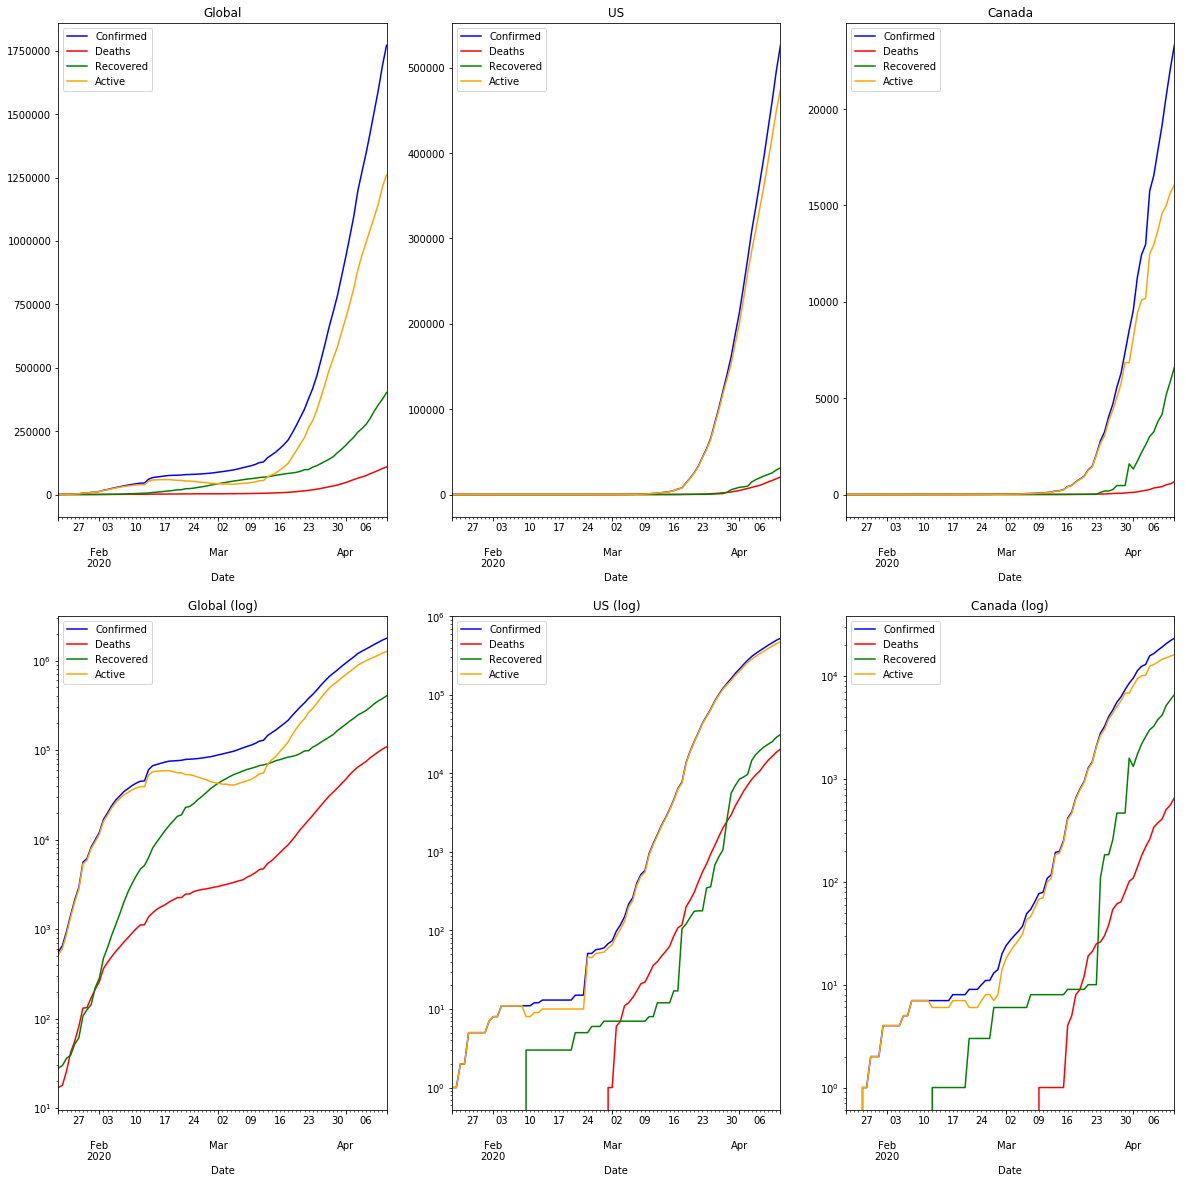

In [9]:
from covid19plot.plot import simpleplot

fig = simpleplot(data)

fig.savefig('out/simple.png')
plt.show()


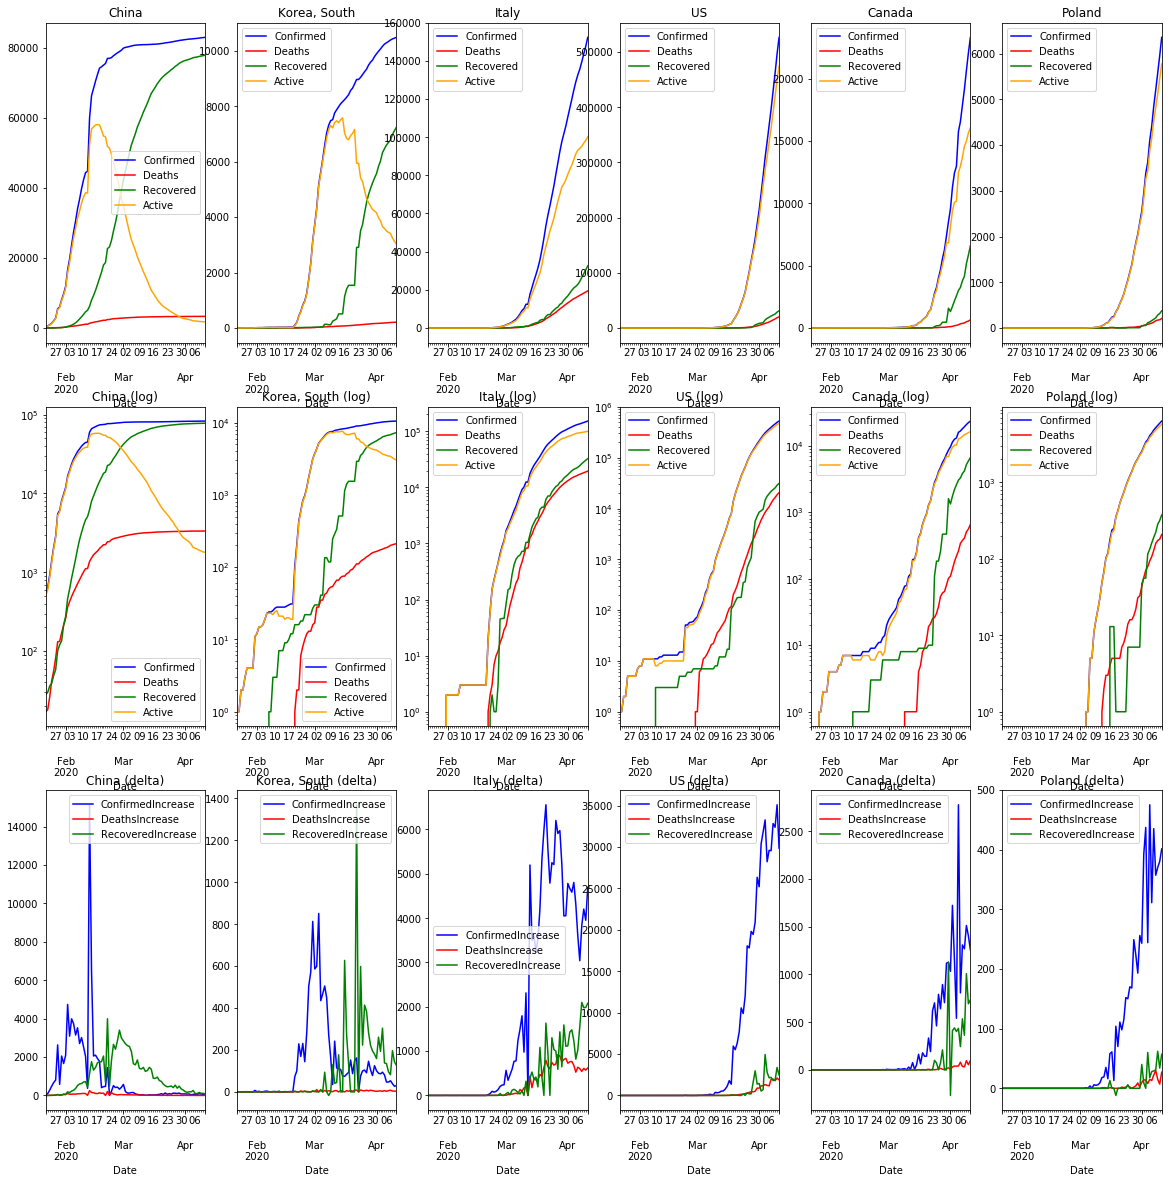

In [10]:
from covid19plot.plot import countryplot

#print(df['Country/Region'].unique())
countries = ['China', 'Korea, South', 'Italy', 'US', 'Canada', 'Poland']

fig = countryplot(data, countries)

fig.savefig('out/countries.png')
plt.show()


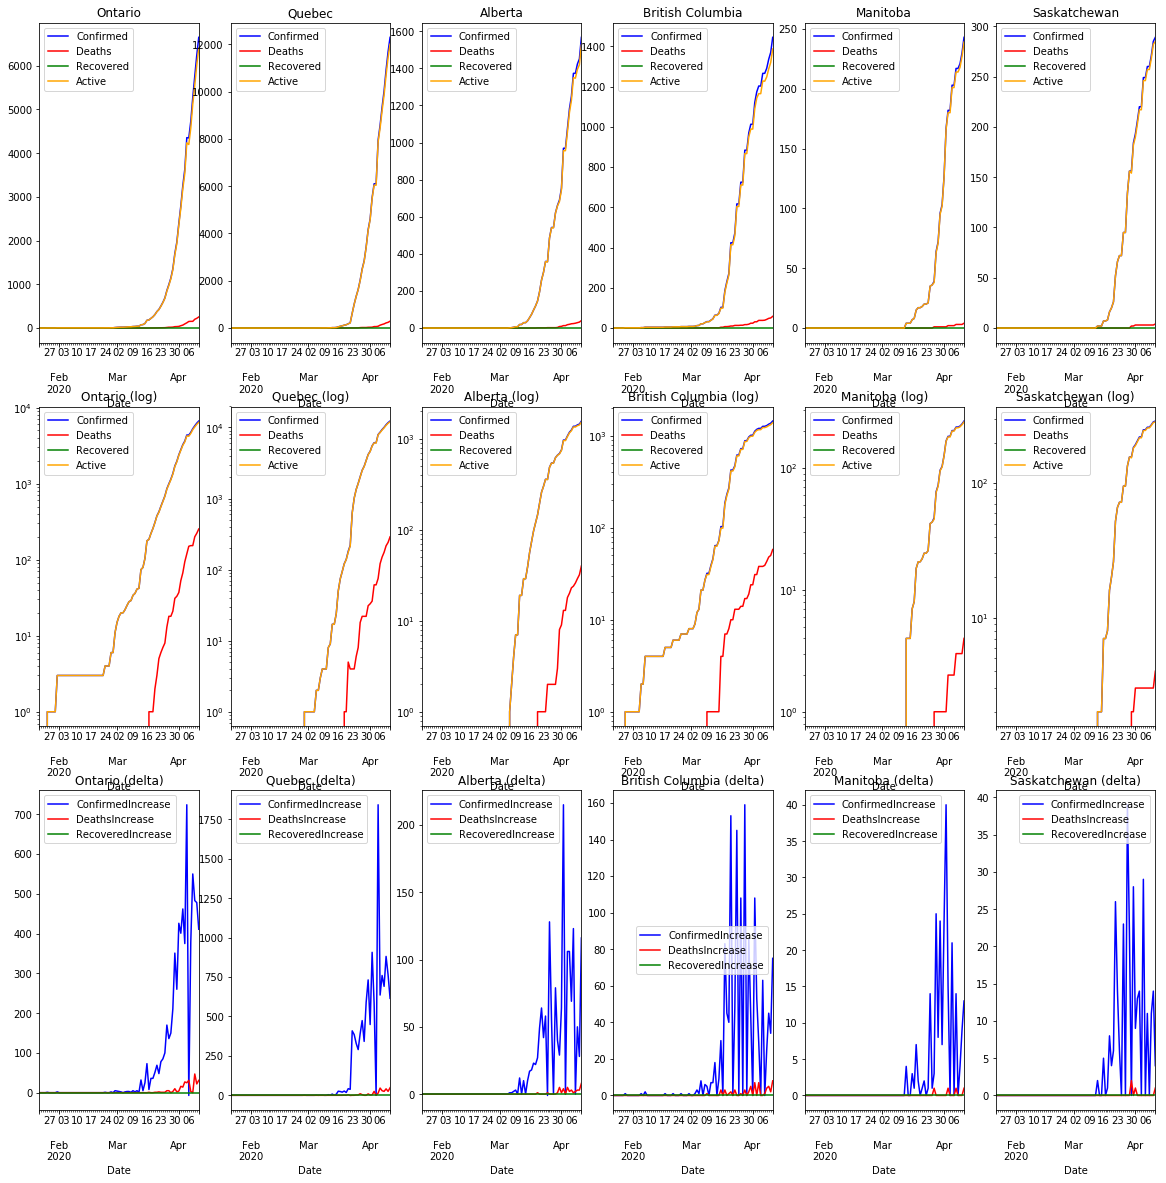

In [11]:
from covid19plot.plot import countryregionplot

country = 'Canada'
regions = ['Ontario', 'Quebec', 'Alberta', 'British Columbia', 'Manitoba', 'Saskatchewan']

#cdf = df.loc[df['Country/Region'] == country]
#regions = cdf['Province/State'].unique()
#regions = regions[0:8]
#print(regions)

fig = countryregionplot(data, country, regions)

fig.savefig('out/canada.png')
plt.show()


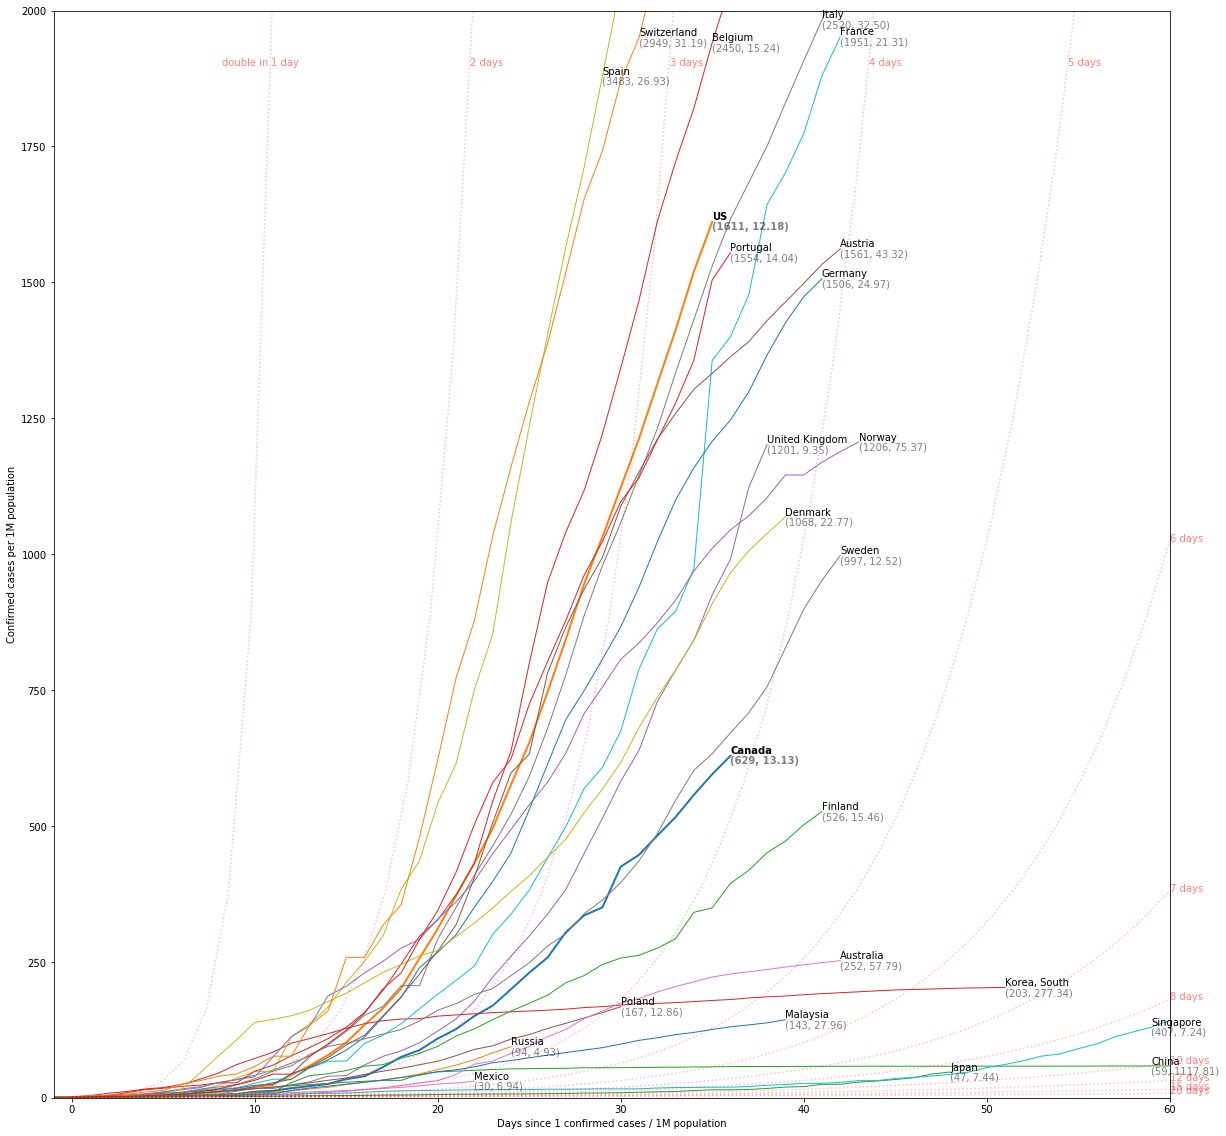

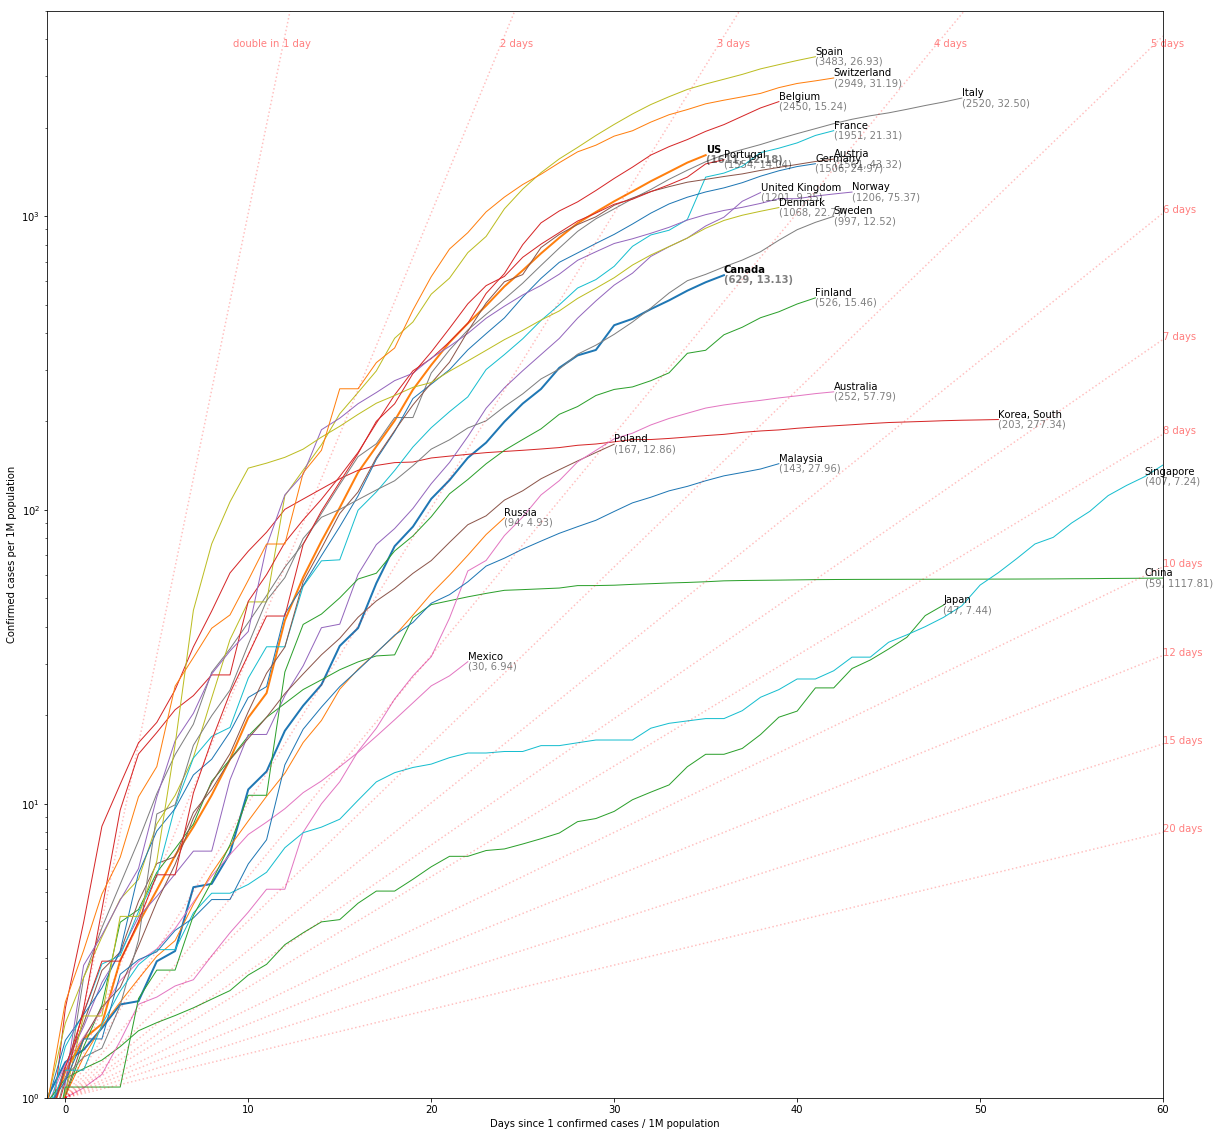

In [14]:
from covid19plot.plot import sinceplot

fig = sinceplot(data, logScale=False)
fig.savefig('out/country-tends.png')

fig = sinceplot(data, logScale=True)
fig.savefig('out/country-tends-log.png')

plt.show()